In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import json

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = 'C:/Users/klouc/Desktop/cogrob/data/rgbd-dataset'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x).replace("//","/"),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(len(dataloaders['train']))

14918


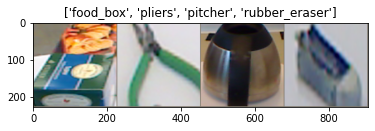

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    results = []
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            epoch_res = {'epoch': epoch + 1}
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                epoch_res[f'{phase}_loss'] = epoch_loss
                epoch_res[f'{phase}_acc'] = epoch_acc.item()

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print(epoch_res)
            results.append(epoch_res)

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, results

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_ft = models.vgg11(weights='IMAGENET1K_V1')
# num_ftrs = model_ft.fc.in_features
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
# model_ft.fc = nn.Linear(num_ftrs, 51)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
model_ft, results = train_model( model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=8)

Epoch 0/7
----------
train Loss: 0.9008 Acc: 0.7454
val Loss: 0.0780 Acc: 0.9725
test Loss: 0.0803 Acc: 0.9715
{'epoch': 1, 'train_loss': 0.9007688019235123, 'train_acc': 0.7454332160214513, 'val_loss': 0.07799713685728994, 'val_acc': 0.9725255371609722, 'test_loss': 0.08028052748274445, 'test_acc': 0.9715219421101774}
Epoch 1/7
----------
train Loss: 0.3232 Acc: 0.9043
val Loss: 0.0201 Acc: 0.9928
test Loss: 0.0186 Acc: 0.9942
{'epoch': 2, 'train_loss': 0.3231984447227667, 'train_acc': 0.9043405396346573, 'val_loss': 0.020061808996947428, 'val_acc': 0.9927791475871787, 'test_loss': 0.01855916577636167, 'test_acc': 0.9941643323996265}
Epoch 2/7
----------
train Loss: 0.2326 Acc: 0.9301
val Loss: 0.0152 Acc: 0.9950
test Loss: 0.0179 Acc: 0.9939
{'epoch': 3, 'train_loss': 0.23259240989922955, 'train_acc': 0.9300653594771242, 'val_loss': 0.015207759468525628, 'val_acc': 0.9949512739227427, 'test_loss': 0.017886752580612713, 'test_acc': 0.9939309056956116}
Epoch 3/7
----------
train Loss: 

In [10]:
print(results)

[{'epoch': 1, 'train_loss': 0.9007688019235123, 'train_acc': 0.7454332160214513, 'val_loss': 0.07799713685728994, 'val_acc': 0.9725255371609722, 'test_loss': 0.08028052748274445, 'test_acc': 0.9715219421101774}, {'epoch': 2, 'train_loss': 0.3231984447227667, 'train_acc': 0.9043405396346573, 'val_loss': 0.020061808996947428, 'val_acc': 0.9927791475871787, 'test_loss': 0.01855916577636167, 'test_acc': 0.9941643323996265}, {'epoch': 3, 'train_loss': 0.23259240989922955, 'train_acc': 0.9300653594771242, 'val_loss': 0.015207759468525628, 'val_acc': 0.9949512739227427, 'test_loss': 0.017886752580612713, 'test_acc': 0.9939309056956116}, {'epoch': 4, 'train_loss': 0.20083384799535914, 'train_acc': 0.9407910172616055, 'val_loss': 0.03787103314465516, 'val_acc': 0.9871433603381473, 'test_loss': 0.038765056413896715, 'test_acc': 0.9870448179271709}, {'epoch': 5, 'train_loss': 0.17454196556216728, 'train_acc': 0.9464890229596112, 'val_loss': 0.014879797724923137, 'val_acc': 0.9958905717975813, 'te

In [13]:
with open('C:/Users/klouc/Desktop/cogrob/vgg11/vgg11_result.json', "w") as json_file:
        json.dump(results, json_file)

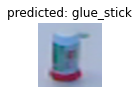

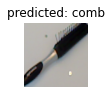

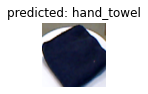

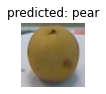

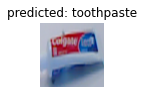

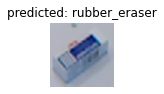

In [ ]:
visualize_model(model_ft)